In [2]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto(
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8),
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [3]:
import random

import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma  
import pandas as pd
import sklearn
import tensorflow as tf

from amp.utils.basic_model_serializer import load_master_model_components
from amp.utils import basic_model_serializer
from amp.inference.filtering import amino_based_filtering         
import amp.data_utils.data_loader as data_loader
from amp.data_utils.sequence import pad, to_one_hot
from amp.utils import phys_chem_propterties as phys

from keras import backend, layers
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras import layers
from pathlib import Path
from keras import models as m
from tqdm import tqdm
from joblib import dump, load
from sklearn.decomposition import PCA
import os
import scipy

import modlamp.descriptors
import modlamp.analysis
import modlamp.sequences

seed = 7

MIN_LENGTH = 0
MAX_LENGTH = 25
latent_dim = 64

input_to_encoder = layers.Input(shape=(MAX_LENGTH,))
input_to_decoder = layers.Input(shape=(latent_dim+2,))

Using TensorFlow backend.


In [4]:
def translate_generated_peptide(encoded_peptide):
    alphabet = list('ACDEFGHIKLMNPQRSTVWY')
    return ''.join([alphabet[el - 1] if el != 0 else "" for el in encoded_peptide.argmax(axis=1)])

def translate_peptide(encoded_peptide):
    alphabet = list('ACDEFGHIKLMNPQRSTVWY')
    return ''.join([alphabet[el-1] if el != 0 else "" for el in encoded_peptide])


In [5]:
from joblib import dump, load
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu
sns.set_style('whitegrid', {'grid.color': '.95', 'axes.spines.right': False, 'axes.spines.top': False})

params = {'axes.labelsize': 8,'axes.titlesize':8, 'font.size': 8, 'legend.fontsize': 6, 'xtick.labelsize': 8, 'ytick.labelsize': 8}
plt.rcParams.update(params)

In [6]:
models = [
    'HydrAMP',
    'PepCVAE',
    'Basic',
]

In [7]:
boxprops = dict(linewidth=0.0, color='k')
flierprops = dict(linewidth=0.5)
medianprops = dict(linewidth=0.5, color='k')
whiskerprops = dict(linewidth=0.5)
capprops = dict(linewidth=0.5)

In [8]:
def calculate_length(data:list):
    lengths = [len(x) for x in data]
    return lengths

def calculate_molarweight(x:list):
    h = modlamp.descriptors.GlobalDescriptor(data)
    h.calculate_MW()
    return list(h.descriptor.flatten())

def calculate_charge(data:list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_charge()
    return h.charge

def calculate_isoelectricpoint(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.isoelectric_point()
    return list(h.descriptor.flatten())

def calculate_aromaticity(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.aromaticity()
    return list(h.descriptor.flatten())


def calculate_hydrophobicity(data:list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_H(scale='eisenberg')
    return list(h.H)


def calculate_hydrophobicmoment(data:list):
    h = modlamp.descriptors.PeptideDescriptor(data, 'eisenberg')
    h.calculate_moment()
    return list(h.descriptor.flatten())

def calculate_alphahelixpropensity(data:list):
    h = modlamp.descriptors.PeptideDescriptor(data, 'levitt_alpha')
    h.calculate_global()
    return list(h.descriptor.flatten())

def calculate_instability_index(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.instability_index()
    return list(h.descriptor.flatten())

def calculate_hscore(data:list):
    return [phys.helical_search(x) for x in data]


def calculate_hydrophobic_ratio(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.hydrophobic_ratio()
    return list(h.descriptor.flatten())
#     return [phys.helical_search(x) for x in data]

def calculate_boman_index(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.boman_index()
    return list(h.descriptor.flatten())


In [9]:
def calculate_physchem(peptides, datasets, n):
    physchem = {}
    physchem['dataset'] = []
    physchem['length'] = []
    physchem['charge'] = []
    physchem['pi'] = []
    physchem['aromacity'] = []
    physchem['hydrophobicity'] = []
    physchem['hm'] = []
    physchem['alpha'] = []
    physchem['boman'] = []
    physchem['h_score'] = []
    physchem['hydrophobic_ratio'] = []
    physchem['instability'] = []

    for dataset, name in zip(peptides, datasets):
        physchem['dataset'] += (len(dataset) * [name])
        physchem['length'] += calculate_length(dataset)
        physchem['charge'] += calculate_charge(dataset)[0].tolist()
        physchem['pi'] += calculate_isoelectricpoint(dataset)
        physchem['aromacity'] += calculate_aromaticity(dataset) 
        physchem['hydrophobicity'] += calculate_hydrophobicity(dataset)[0].tolist()
        physchem['hm'] += calculate_hydrophobicmoment(dataset)
        physchem['alpha'] += calculate_alphahelixpropensity(dataset)
        physchem['boman'] += calculate_boman_index(dataset)
        physchem['hydrophobic_ratio'] += calculate_hydrophobic_ratio(dataset)
        physchem['h_score'] += calculate_hscore(dataset)        
        physchem['instability'] += calculate_instability_index(dataset)

    return pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in physchem.items() ]))

In [10]:
def select_peptides(results):
    peptides = np.array([translate_peptide(x) for x in results['new_peptides']]).reshape(64, -1)
    amp = (results['new_amp'] < 0.8).reshape(64, -1)
    mic = results['new_mic'].reshape(64, -1)
    combined = ma.masked_where(amp, mic)
    good = combined.argmax(axis=0)
    good_peptides = peptides[good, list(range(peptides.shape[1]))]
    good_amp = np.array(results['new_amp']).reshape(64, -1).T[list(range(peptides.shape[1])), good]
    good_mic = np.array(results['new_mic']).reshape(64, -1).T[list(range(peptides.shape[1])), good]
    return pd.DataFrame.from_dict({
        'sequence': good_peptides.tolist(), 
        'amp': good_amp.tolist(),
        'mic': good_mic.tolist(),
    }
        )

## Prepare data

In [11]:
random.seed(seed)
data_manager = data_loader.AMPDataManager(
    '../data/unlabelled_positive.csv',
    '../data/unlabelled_negative.csv',
    min_len=MIN_LENGTH,
    max_len=MAX_LENGTH)

amp_x, amp_y = data_manager.get_merged_data()
amp_x_train, amp_x_test, amp_y_train, amp_y_test = train_test_split(amp_x, amp_y, test_size=0.1, random_state=36)
amp_x_train, amp_x_val, amp_y_train, amp_y_val = train_test_split(amp_x_train, amp_y_train, test_size=0.2, random_state=36)


# Restrict the length
ecoli_df = pd.read_csv('../data/mic_data.csv')
mask = (ecoli_df['sequence'].str.len() <= MAX_LENGTH) & (ecoli_df['sequence'].str.len() >= MIN_LENGTH)
ecoli_df = ecoli_df.loc[mask]
mic_x = pad(to_one_hot(ecoli_df['sequence']))
mic_y = ecoli_df.value

mic_x_train, mic_x_test, mic_y_train, mic_y_test = train_test_split(mic_x, mic_y, test_size=0.1, random_state=36)
mic_x_train, mic_x_val, mic_y_train, mic_y_val = train_test_split(mic_x_train, mic_y_train, test_size=0.2, random_state=36)


pos = np.vstack([amp_x_test[amp_y_test == 1], mic_x_test[mic_y_test < 1.5]])
neg = np.vstack([amp_x_test[amp_y_test == 0], mic_x_test[mic_y_test > 1.5]])
positives = [translate_peptide(x) for x in pos]
negatives = [translate_peptide(x) for x in neg]

#Load Uniprot
uniprot = list(pd.read_csv('../data/Uniprot_0_25_test.csv').Sequence)
uniprot = random.sample(uniprot, 1253)


#Get random peptides
random_gen = modlamp.sequences.Random(1253, 1, 25)
random_gen.generate_sequences(proba='random')
random_peptides = random_gen.sequences


/home/pszymczak/amp/new-tf/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/pszymczak/amp/new-tf/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [12]:
impr0_neg = load(f'../results/z_sigma_improvement_0_NegTest.joblib')
impr2_neg = load(f'../results/z_sigma_improvement_2_NegTest.joblib')
impr5_neg = load(f'../results/z_sigma_improvement_5_NegTest.joblib')
pepcvae_neg = load(f'../results/improvement_NegTest.joblib')['PepCVAE']
basic_neg = load(f'../results/improvement_NegTest.joblib')['Basic']


impr0_pos = load(f'../results/z_sigma_improvement_0_PosTest.joblib')
impr2_pos = load(f'../results/z_sigma_improvement_2_PosTest.joblib')
impr5_pos = load(f'../results/z_sigma_improvement_5_PosTest.joblib')
pepcvae_pos = load(f'../results/improvement_PosTest.joblib')['PepCVAE']
basic_pos = load(f'../results/improvement_PosTest.joblib')['Basic']


In [13]:
impr0_neg = select_peptides(impr0_neg).sequence.tolist()
impr2_neg = select_peptides(impr2_neg).sequence.tolist()
impr5_neg = select_peptides(impr5_neg).sequence.tolist()
pepcvae_neg = select_peptides(pepcvae_neg).sequence.tolist()
basic_neg = select_peptides(basic_neg).sequence.tolist()

impr0_pos = select_peptides(impr0_pos).sequence.tolist()
impr2_pos = select_peptides(impr2_pos).sequence.tolist()
impr5_pos = select_peptides(impr5_pos).sequence.tolist()
pepcvae_pos = select_peptides(pepcvae_pos).sequence.tolist()
basic_pos = select_peptides(basic_pos).sequence.tolist()

In [14]:
datasets_0 = {
    'Random': random_peptides, 
    'Uniprot': uniprot, 
    'Non-AMP test data': negatives,
    'AMP test data': positives,
}

datasets_neg = {
    'HydrAMP τ=0': impr0_neg,
    'HydrAMP τ=2': impr2_neg,
    'HydrAMP τ=5': impr5_neg,        
    'PepCVAE': pepcvae_neg,
    'Basic': basic_neg,
}

datasets_pos = {
    'HydrAMP τ=0': impr0_pos,
    'HydrAMP τ=2': impr2_pos,
    'HydrAMP τ=5': impr5_pos,        
    'PepCVAE': pepcvae_pos,
    'Basic': basic_pos,
}


In [15]:
datasets_0_df = calculate_physchem(datasets_0.values(), datasets_0.keys(), 10000)
datasets_neg_df = calculate_physchem(datasets_neg.values(), datasets_neg.keys(), 10000)
datasets_pos_df = calculate_physchem(datasets_pos.values(), datasets_pos.keys(), 10000)

/home/pszymczak/amp/new-tf/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pszymczak/amp/new-tf/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [48]:
hydra_color = '#B80018'
pepcvae_color = '#1d3557'
basic_color = '#B4C5E4'

palette_0 = {
    'Random': 'grey', 
    'Uniprot': 'lightgray', 
    'Non-AMP test data': '#66BDBA',
    'AMP test data': '#F7CF8B',
}    
    
palette_models = {  
    'HydrAMP τ=0': '#F2696B',
    'HydrAMP τ=2': '#D91115',
    'HydrAMP τ=5': '#660708',         
    'PepCVAE': pepcvae_color,
    'Basic': basic_color,
}

properties = {
    'pi': 'Isoelectric point',
    'charge': 'Charge',
    'hydrophobic_ratio': 'Hydrophobic moment',
    'aromacity': 'Aromaticity',
}

datasets = [datasets_0, datasets_neg, datasets_pos]
datasets_df = [datasets_0_df, datasets_neg_df, datasets_pos_df]
palettes = [palette_0, palette_models, palette_models]


In [49]:
def wilcox(wilx_prop):
    if wilx_prop > 0.05:
        symbol = 'ns'
    if wilx_prop <= 0.05:
        symbol = '*'
    if wilx_prop <= 0.01:
        symbol = '**'
    if wilx_prop <= 0.001:
        symbol = '***'
    return symbol
    

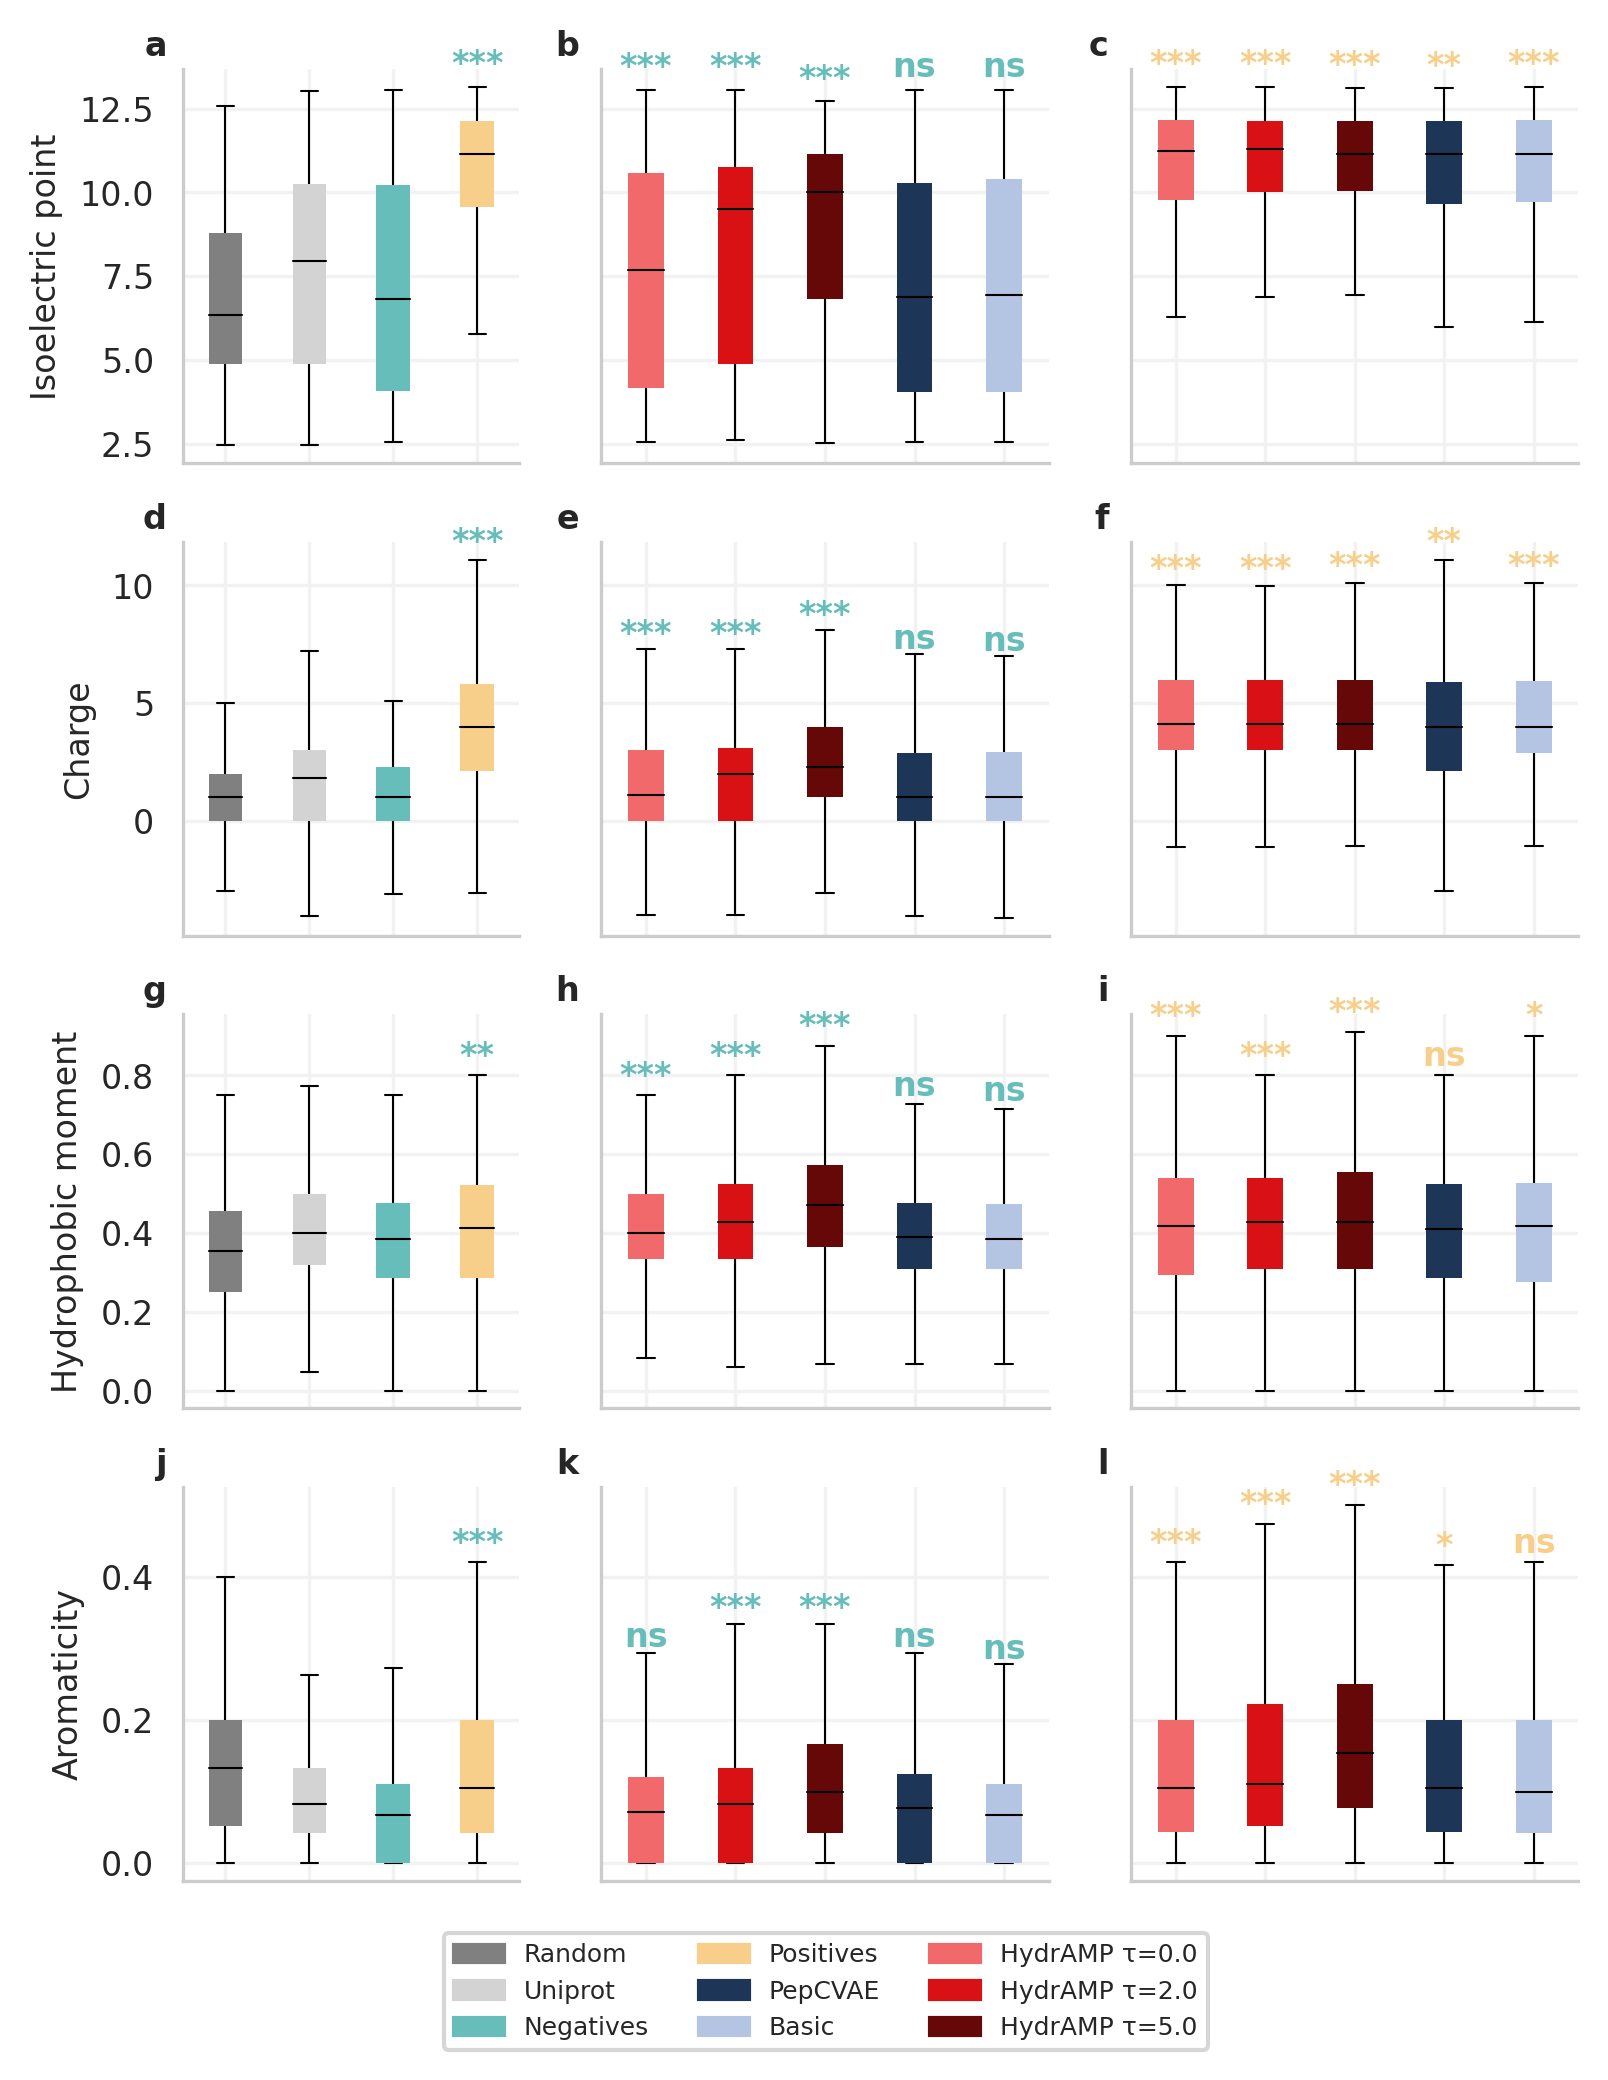

In [50]:
fig, axes = plt.subplots(
    ncols=3, 
    nrows=4,
    figsize=(6, 8),
    dpi=300,
    gridspec_kw={'width_ratios': [1.5, 2, 2]},
    sharey='row'
)


for prop, ax in zip(properties.keys(), axes):
    boxplots = []
    for dataset, physchem, subplot, palette in zip(datasets, datasets_df, ax, palettes):
        
        data = [physchem[physchem['dataset'] == x][prop].tolist() for x in dataset.keys()]
        parts = subplot.boxplot(
            data,
            showfliers=False,
            patch_artist=True,
            boxprops=boxprops,
            flierprops=flierprops,
            medianprops=medianprops,
            whiskerprops=whiskerprops,
            capprops=capprops,
            widths=0.4      
        )
        boxplots.append(parts)
        for patch, color in zip(parts['boxes'], palette.values()):
            patch.set_facecolor(color)     
            
        subplot.set_xticklabels([])

## AX0 - random, uniprot, pos, neg

    ax[0].set_ylabel(properties[prop])
    wilx_prop = mannwhitneyu(
        datasets_0_df[datasets_0_df.dataset == 'AMP test data'][prop],
        datasets_0_df[datasets_0_df.dataset == 'Non-AMP test data'][prop], 
        alternative='greater'
    )[1]
    symbol = wilcox(wilx_prop)
    
    
#     print(prop, wilx_prop)

    ax[0].text(
        x=4,
        y=01.03 * boxplots[0]['caps'][7].get_ydata()[0],
        s=symbol,
        ha='center',
        color=palette_0['Non-AMP test data'],
        weight='bold',            
    )    
    
## AX1 - improving negatives     
    for ind, (dataset, cap_id) in enumerate(zip(datasets[1].keys(), [x for x in range(1,10,2)])):
        wilx_prop = wilcoxon(
            datasets_neg_df[datasets_neg_df.dataset == dataset][prop],
            datasets_0_df[datasets_0_df.dataset == 'Non-AMP test data'][prop], 
            alternative='greater'
        )[1]
        symbol = wilcox(wilx_prop)
    
    
#         print(prop, dataset, wilx_prop)

        ax[1].text(
            x=ind+1,
            y=1.03 * boxplots[1]['caps'][cap_id].get_ydata()[0],
            s=symbol,
            ha='center',
            color=palette_0['Non-AMP test data'],
            weight='bold',            
        )
    
## AX2 - improving positives    
    for ind, (dataset, cap_id) in enumerate(zip(datasets[2].keys(), [x for x in range(1,10,2)])):
        wilx_prop = wilcoxon(
            datasets_pos_df[datasets_pos_df.dataset == dataset][prop],
            datasets_0_df[datasets_0_df.dataset == 'AMP test data'][prop], 
            alternative='greater'
        )[1]
        symbol = wilcox(wilx_prop)
    
    
#         print(prop, dataset, wilx_prop)

        ax[2].text(
            x=ind+1,
            y=1.03 * boxplots[2]['caps'][cap_id].get_ydata()[0],
            s=symbol,
            ha='center',
            color=palette_0['AMP test data'],
            weight='bold',
        )
    
    
    
#     ax1.set_ylabel(label[1])    
#     ax0.set_xticklabels([])
#     ax1.set_xticklabels([]) 
    
plt.legend(
    handles=[
        mpatches.Patch(color=palette_0['Random'], label='Random'),
        mpatches.Patch(color=palette_0['Uniprot'], label='Uniprot'),  
        mpatches.Patch(color=palette_0['Non-AMP test data'], label='Negatives'),  
        mpatches.Patch(color=palette_0['AMP test data'], label='Positives'),   
        mpatches.Patch(color=palette_models['PepCVAE'], label='PepCVAE'),
        mpatches.Patch(color=palette_models['Basic'], label='Basic'),          
        mpatches.Patch(color=palette_models['HydrAMP τ=0'], label='HydrAMP τ=0.0'),
        mpatches.Patch(color=palette_models['HydrAMP τ=2'], label='HydrAMP τ=2.0'),
        mpatches.Patch(color=palette_models['HydrAMP τ=5'], label='HydrAMP τ=5.0'),
    ], 
    bbox_to_anchor = (0.20, -0.1),
    ncol=3,
)

for i, (label, ax) in enumerate(
    zip(
        ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'],
        [axes[0][0], axes[0][1], axes[0][2],
        axes[1][0], axes[1][1], axes[1][2],
        axes[2][0], axes[2][1], axes[2][2],
        axes[3][0], axes[3][1], axes[3][2],
        ]
    )
):
    ax.annotate(label, xy=(-0.05, 1.1), xycoords='axes fraction',
      fontweight='bold', va='top', ha='right')
    
# fig.tight_layout()
fig.savefig("../figures/Fig3-Wilcox.svg")
fig.savefig("../figures/Fig3-Wilcox.pdf", bbox_inches="tight")

# plt.show()
# fig.subplots_adjust(hspace=0.3)
plt.show()

In [51]:
print('HydrAMP τ=0')
datasets_pos_df[datasets_pos_df.dataset == 'HydrAMP τ=0']['pi'].describe()

HydrAMP τ=0


count    1319.000000
mean       10.410124
std         2.441069
min         2.467773
25%         9.769531
50%        11.219238
75%        12.156250
max        13.141602
Name: pi, dtype: float64

In [45]:
print('HydrAMP τ=2')
datasets_pos_df[datasets_pos_df.dataset == 'HydrAMP τ=2']['pi'].describe()

HydrAMP τ=2


count    1319.000000
mean       10.569677
std         2.240149
min         2.467773
25%        10.013672
50%        11.278809
75%        12.130859
max        13.141602
Name: pi, dtype: float64

In [46]:
print('HydrAMP τ=5')
datasets_pos_df[datasets_pos_df.dataset == 'HydrAMP τ=5']['pi'].describe()

HydrAMP τ=5


count    1319.000000
mean       10.743827
std         1.890343
min         2.497070
25%        10.031250
50%        11.156738
75%        12.129883
max        13.102051
Name: pi, dtype: float64

In [47]:
print('AMP test data')
datasets_0_df[datasets_0_df.dataset == 'AMP test data']['pi'].describe()

AMP test data


count    1319.000000
mean       10.212543
std         2.643494
min         2.467773
25%         9.575439
50%        11.151855
75%        12.130859
max        13.141602
Name: pi, dtype: float64

In [41]:
datasets_pos_df[datasets_pos_df.dataset == 'HydrAMP τ=0']['charge'].describe()

count    1319.000000
mean        4.289460
std         2.561933
min        -5.001000
25%         2.995000
50%         4.094000
75%         5.994000
max        15.995000
Name: charge, dtype: float64

In [42]:
datasets_0_df[datasets_0_df.dataset == 'AMP test data']['charge'].describe()

count    1319.000000
mean        4.075306
std         2.675360
min        -5.999000
25%         2.096000
50%         3.996000
75%         5.823000
max        15.995000
Name: charge, dtype: float64